# AlphaGear POC

	- Game setting
		○ 1 agent only, 1 neutral
	- Environment
		○ State (one-hot encoded) = 
			- [States owned] N 
			- [States opponent owned] N
			- Soldiers on each square (max soldiers x N)^N
			- So if we play on even a toy map: 5 x 5 with max 10 soldiers, that is: 5 x 5 x (10 x 5) ^ 5 = 7E9 states
		○ State (functional approx)
			- State distribution [size M players x N tiles]
		○ Simple grid - POC_grid.xlsx
			- No fog
		○ Env_init
			- Randomly distribute the state w/ 3 troops
		○ Env_step
			- Dynamics
				□ Still dictated by the attacking logic 
					® + Attacker gets 3 troops at the territory they attack from?
					® Attacker gets + 3 troops for each group of territories they own
				□ Need to move all troops over
	- Actions
		○ [Attack up, Attack down, Attack left, Attack right, Do nothing]
			- Attacking into your own territory effectively does nothing
		○ 1 per turn
		○ Exploration with softmax
		
	- Rewards
		○ +1 for winning the game
		
    - Algorithm = Expected Sarsa![image.png](attachment:image.png)

## Creating the Environment

In [1]:
from Coursera_lab_files import environment
from dynamics import *
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

class RiskEnvironmentPOC(environment.BaseEnvironment):
    def __init__(self):
        self.current_state = None
        self.count = 0
        
    def env_init(self, env_info):
        # users set this up
        """Setup for the environment called when the experiment first starts.

        Note:
            Initialize a tuple with the reward, first state observation, boolean
            indicating if it's terminal.
        """
        self.state = np.array([0, np.zeros(env_info['states']), False]) #reward, state init, boolean
        # number of states - should be a perfect square                 
        # Does not need to return anything
    
    def env_start(self):
        """The first method called when the experiment starts, called before the
        agent starts.

        Returns:
            The first state observation from the environment.
        """
        # Set up the board with troops
        # where 'positive = agent troops' and 'negative = neutral troops'
        states_remaining = list(range(len(self.state[1]))) # list of states to choose from
        turn = True # whether it is the turn of the agent to be assigned troops somewhere or not
        
        for i in range(len(self.state[1])):
            
            # determine index to assign troops to
            index = random.choice(states_remaining)
            states_remaining.remove(index)
            
            if turn == True:
                self.state[1][index] = 3
                turn = False
            else:
                self.state[1][index] = -3
                turn = True  

        self.current_state = self.state[1]
        return self.current_state
    
    def env_step(self, action):
        """A step taken by the environment.

        Args:
            action: The action taken by the agent

        Returns:
            (float, state, Boolean): a tuple of the reward, state observation,
                and boolean indicating if it's terminal.
        """
        #############
        # Dynamics
        ### functions that take in the action and return the observation
        # X = func(action)
        # initialize
        terminal = False
        reward = 0.0
        observation = action_state(self.state[1], action, len(self.state[1])*5) # state from dynamics
        #############
        
        # use the above observations to decide what the reward will be, and if the agent is in a terminal state.
        
        #############
        # Reward function
        
        # In this simple implementation (where + numbers represent the agents territories, the game is over when all numbers in the grid are positive)
        comparison = np.where(observation < 0, observation, 0) == np.zeros(len(self.state[1])) # True if no negatives

        if comparison.all():
            # agent wins                
            terminal = True
            reward += 1
         
        else: 
            # continue
            terminal = False
            reward += 0.0
        #############
        
        self.state[0] = reward
        self.state[1] = observation
        self.state[2] = terminal
        self.current_state = self.state[1]
        
        self.reward_obs_term = (reward, observation, terminal)
        return self.reward_obs_term
    
    def env_cleanup(self):
        return None
    
    def env_message(self):
        return None
    
    def env_print_state(self):
        dim = int(np.sqrt(len(self.state[1])))
        grid = self.state[1].reshape((dim,dim), order = "C")

        # determine who owns which territories
        player_squares = np.zeros(len(self.state[1]))
        for i in range(len(player_squares)):
            if self.state[1][i] > 0:
                player_squares[i] = 1
            else:
                player_squares[i] = 0
        grid_player = player_squares.reshape((dim,dim), order = "C")
        
        cmap = ListedColormap(['blue', 'grey']) # player colors
        ax = sns.heatmap(grid_player, cmap=cmap, annot=grid, cbar=False)
        
        #plot the borders
        for i in range(grid.shape[1]+1):
            if (i == int(dim/2+1)) or (i == int(dim/2)):  
                ax.axvline(i, color='white', lw=2)
                ax.axhline(i, color='white', lw=2)

        plt.xticks(np.arange(0, dim+1, 1.0))
        plt.yticks(np.arange(0, dim+1, 1.0))
        plt.show()

C:\Users\david\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Testing

In [2]:
environment = RiskEnvironmentPOC()
env_info = {'states':25}

C:\Users\david\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


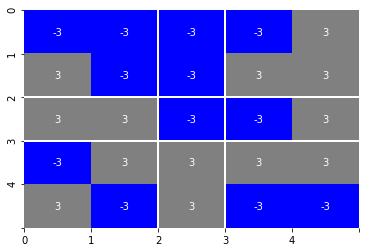

In [3]:
environment.env_init(env_info)
environment.env_start()
# print(environment.state)
environment.env_print_state()

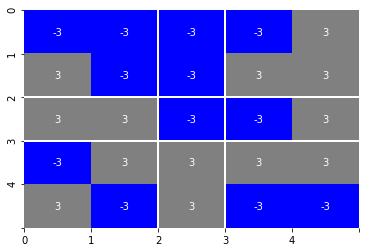

In [4]:
# action 0 should be from top right cell -> up (= nothing)
reward, obs, term = environment.env_step(0)
environment.env_print_state()


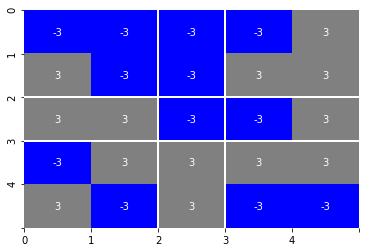

In [5]:
# action 1 should be from top right cell -> down
reward, obs, term = environment.env_step(1)
environment.env_print_state()

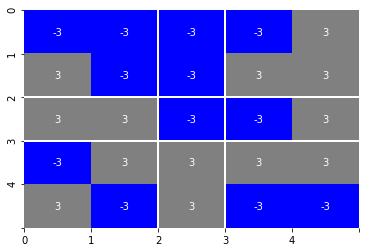

In [6]:
# action 2 should be from top right cell -> left (= nothing)
reward, obs, term = environment.env_step(2)
environment.env_print_state()

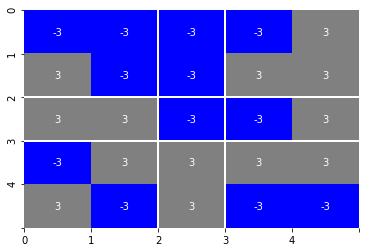

In [7]:
# action 3 should be from top right cell -> right 
reward, obs, term = environment.env_step(3)
environment.env_print_state()

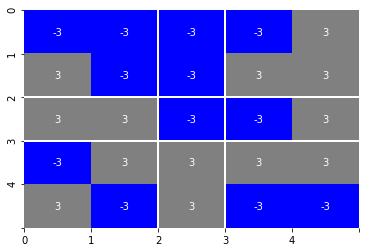

In [8]:
# action 4 should be to do nothing
reward, obs, term = environment.env_step(4)
environment.env_print_state()